**Deadline** до 1 июня 2021 23:59

1. Обучить сеть DeepFM на бинарную задачу классифкации на датасете "adult".
2. Обучающая и валидационная выборки лежат в папке data в week08 и сам проект в папке DeepFM.
3. Перед обучением сети првоести анализ и предобработку данных.
4. Выложить код и показать точность и графики обучения.

In [1]:
import torch
print(torch.__version__)

import warnings
warnings.filterwarnings("ignore")

import torch.optim as optim
import torch.utils.data as data_utils

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
from pytorch_lightning.metrics import Accuracy

from network import DeepFMNet
from data_loader import CustomDataset
from dataset_utils import preprocessing
from train import DeepFM

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.6.0+cpu


In [2]:
EPOCHS = 20
EMBEDDING_SIZE = 5
BATCH_SIZE = 512
NROF_LAYERS = 3
NROF_NEURONS = 50
DEEP_OUTPUT_SIZE = 50
NROF_OUT_CLASSES = 1
LEARNING_RATE = 3e-4
FILE_PATH = r"adult.csv"

In [3]:
data = pd.read_csv(FILE_PATH)

In [5]:
data.shape

(32561, 15)

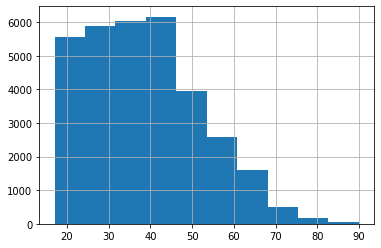

In [120]:
data['age'].hist()

In [6]:
data = data[data.age.lt(65)]

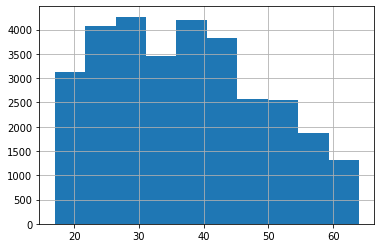

In [122]:
data.age.hist()

In [7]:
data.workclass.value_counts()

 Private             22142
 Self-emp-not-inc     2335
 Local-gov            2015
 ?                    1491
 State-gov            1263
 Self-emp-inc         1026
 Federal-gov           937
 Without-pay             9
 Never-worked            7
Name: workclass, dtype: int64

In [8]:
data['workclass'] = data.workclass.replace(' ?', np.nan)
data = data[~data.workclass.isin([' Without-pay', ' Never-worked'])]

In [9]:
data.education.value_counts()

 HS-grad         10062
 Some-college     7069
 Bachelors        5186
 Masters          1654
 Assoc-voc        1339
 11th             1124
 Assoc-acdm       1049
 10th              874
 7th-8th           544
 Prof-school       536
 9th               474
 12th              426
 Doctorate         374
 5th-6th           302
 1st-4th           150
 Preschool          46
Name: education, dtype: int64

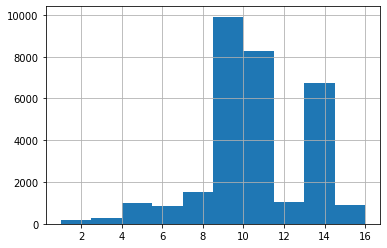

In [126]:
data['education-num'].hist()

In [11]:
data = data[data['education-num'].ge(6) & ~data.education.isin([' Preschool', ' 1st-4th'])]

In [12]:
data['marital-status'].value_counts()

 Married-civ-spouse       13244
 Never-married            10044
 Divorced                  4099
 Separated                  913
 Widowed                    579
 Married-spouse-absent      341
 Married-AF-spouse           22
Name: marital-status, dtype: int64

In [13]:
data = data[~data['marital-status'].isin([' Married-AF-spouse'])]

In [14]:
data['occupation'].value_counts()

 Prof-specialty       3895
 Exec-managerial      3770
 Craft-repair         3679
 Adm-clerical         3538
 Sales                3342
 Other-service        2821
 Machine-op-inspct    1677
 Transport-moving     1391
 ?                    1364
 Handlers-cleaners    1159
 Tech-support          882
 Farming-fishing       759
 Protective-serv       603
 Priv-house-serv        91
 Armed-Forces            9
Name: occupation, dtype: int64

In [15]:
data['occupation'] = data.occupation.replace(' ?', np.nan)
data = data[~data.occupation.isin([' Priv-house-serv', ' Armed-Forces'])]

In [16]:
data.relationship.value_counts()

 Husband           11612
 Not-in-family      7411
 Own-child          4791
 Unmarried          3081
 Wife               1425
 Other-relative      800
Name: relationship, dtype: int64

In [17]:
data.race.value_counts()

 White                 24861
 Black                  2821
 Asian-Pac-Islander      947
 Amer-Indian-Eskimo      275
 Other                   216
Name: race, dtype: int64

In [18]:
data['race'] = data.race.replace(' Amer-Indian-Eskimo', ' Other')

In [19]:
data.sex.value_counts()

 Male      19440
 Female     9680
Name: sex, dtype: int64

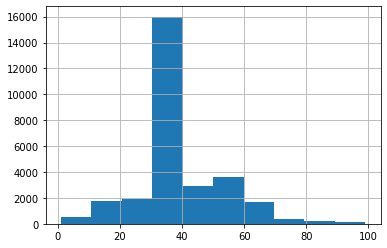

In [136]:
data['hours-per-week'].hist();

In [20]:
data = data[data['hours-per-week'].ge(20)]

In [21]:
data['native-country'].value_counts()

 United-States                 25371
 ?                               490
 Mexico                          290
 Philippines                     166
 Germany                         120
 Canada                           99
 India                            92
 Puerto-Rico                      79
 England                          77
 Jamaica                          73
 South                            71
 Cuba                             68
 China                            59
 Japan                            58
 El-Salvador                      53
 Vietnam                          53
 Columbia                         50
 Italy                            50
 Poland                           48
 Taiwan                           46
 Dominican-Republic               43
 Iran                             42
 Haiti                            35
 Nicaragua                        27
 Guatemala                        27
 Peru                             26
 France                           25
 

In [22]:
continents = {'US&Canada': [' United-States', ' Puerto-Rico', ' Haiti', ' Outlying-US(Guam-USVI-etc)', ' Canada'],
             'Latin&SA': [' Mexico', ' El-Salvador', 'Cuba', ' Jamaica', ' Dominican-Republic', 
                       ' Guatemala', ' Honduras', ' Trinadad&Tobago', ' Columbia', ' Nicaragua', ' Peru', ' Ecuador'],
             'Asia': [' Philippines', ' India', ' South', ' China', ' Vietnam', ' Japan', 'Taiwan', ' Iran',
                      ' Hong', ' Cambodia', ' Laos', ' Thailand'],
             'Europe': [' Germany', ' England', ' Italy', ' Poland', ' Portugal', ' Greece', ' France', ' Ireland', ' Yugoslavia',
                        ' Hungary', ' Scotland', ' Holand-Netherlands']
}

In [23]:
countries = {}
for continent in continents:
      for country in continents[continent]:
            countries[country] = continent

In [24]:
data['native-country'] = data['native-country'].replace(' ?', np.nan)
data['native-country'] = data['native-country'].map(countries)

In [25]:
data['native-country'].value_counts()

US&Canada    25597
Latin&SA       635
Asia           600
Europe         417
Name: native-country, dtype: int64

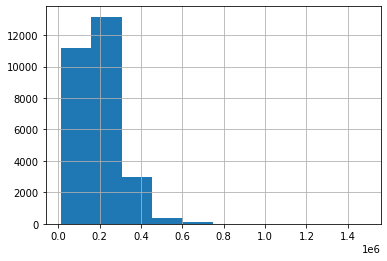

In [147]:
data.fnlwgt.hist()

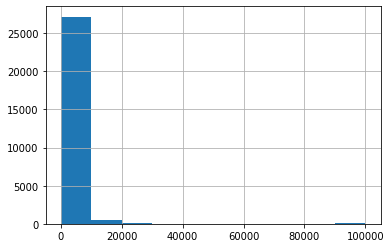

In [152]:
data['capital-gain'].hist()

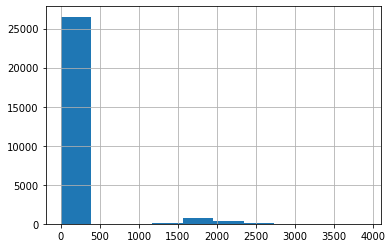

In [151]:
data['capital-loss'].hist()

In [26]:
data.salary.value_counts()

<50k     20564
>=50k     7289
Name: salary, dtype: int64

In [27]:
data.isna().mean()

age               0.000000
workclass         0.041899
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.049833
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.021685
salary            0.000000
dtype: float64

In [28]:
data = data.dropna()
data.isna().mean()

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
salary            0.0
dtype: float64

In [29]:
data.shape

(25893, 15)

In [30]:
data.to_csv(FILE_PATH, index=False)

In [37]:
train_adult = data.sample(frac=0.8, random_state=10)
valid_adult = data[~data.index.isin(train_adult.index)]

In [40]:
with open('train_adult.pickle', 'wb') as f:
    pickle.dump([train_adult, {}, {}], f)
    
with open('valid_adult.pickle', 'wb') as f:
    pickle.dump([valid_adult, {}, {}], f)

In [7]:
preprocessing()

In [3]:
deep_fm = DeepFM()
deep_fm.run_train()

Run train ...
EPOCH 0 STEP 20 : train_loss: 0.753891 train_acc: 0.597656
EPOCH 0 STEP 40 : train_loss: 0.682948 train_acc: 0.644531
EPOCH 0 : valid_acc: 0.645299
EPOCH 1 STEP 60 : train_loss: 0.566742 train_acc: 0.701172
EPOCH 1 STEP 80 : train_loss: 0.450507 train_acc: 0.787109
EPOCH 1 : valid_acc: 0.790598
EPOCH 2 STEP 100 : train_loss: 0.408783 train_acc: 0.798828
EPOCH 2 STEP 120 : train_loss: 0.343100 train_acc: 0.843750
EPOCH 2 : valid_acc: 0.803419
EPOCH 3 STEP 140 : train_loss: 0.339100 train_acc: 0.820312
EPOCH 3 STEP 160 : train_loss: 0.351077 train_acc: 0.818359
EPOCH 3 : valid_acc: 0.833333
EPOCH 4 STEP 180 : train_loss: 0.357219 train_acc: 0.828125
EPOCH 4 STEP 200 : train_loss: 0.289255 train_acc: 0.873047
EPOCH 4 : valid_acc: 0.829060
EPOCH 5 STEP 220 : train_loss: 0.324636 train_acc: 0.837891
EPOCH 5 STEP 240 : train_loss: 0.346514 train_acc: 0.841797
EPOCH 5 : valid_acc: 0.833333
EPOCH 6 STEP 260 : train_loss: 0.352484 train_acc: 0.837891
EPOCH 6 STEP 280 : train_loss:

In [4]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7472), started 0:19:06 ago. (Use '!kill 7472' to kill it.)